Using backend: tensorflow.compat.v1

2021-12-10 14:57:35.594773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term




heat_1d_boundary_sin_exact: Average time with 15 tries: 0.0002 seconds
finite_difference_crank_nicolson: Average time with 15 tries: 0.0097 seconds


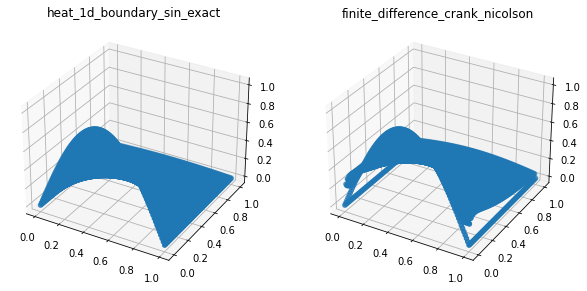

In [1]:
from dataclasses import dataclass

import numpy as np
import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import Plotter
from project.timer import Timer

TIMER_REPEAT_TIMES = 15

# Problem parameters:
@dataclass
class PinnConstParam:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar, Assum x starts at 0
    n = 1 # Frequency of the sinusoidal initial conditions
    t_end = 1 # Assume t_start  = 0
    test_x_dim = 100
    test_t_dim = 100
    analytical_function_name = "heat_1d_boundary_sin_exact"
    numerical_function_name = "finite_difference_crank_nicolson"
    X_test = None
    y_analytical = None
    y_numerical = None

@dataclass
class PinnTestParam:
    d_num_domain = 2540
    d_num_boundary = 80
    d_num_initial = 160
    nn_hidden_layer_size = 20
    nn_hidden_layer_num = 3

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - const_params.a*dy_xx

def create_model(const_params: PinnConstParam, test_params: PinnTestParam):
    # Computational geometry:
    geom = dde.geometry.Interval(0, const_params.L)
    timedomain = dde.geometry.TimeDomain(0, const_params.t_end)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(const_params.n*np.pi*x[:, 0:1]/const_params.L) , lambda _, on_initial: on_initial
        )

    geomtime_data = dde.data.TimePDE(
        geomtime, pde, [bc, ic],
        num_domain=test_params.d_num_domain,
        num_boundary=test_params.d_num_boundary,
        num_initial=test_params.d_num_initial,
        num_test=2540
    )

    nn_architecture = [2] + [test_params.nn_hidden_layer_size] * test_params.nn_hidden_layer_num + [1]
    net = dde.nn.FNN(
        nn_architecture,
        "tanh",
        "Glorot normal")

    model = dde.Model(geomtime_data, net)

    return geomtime_data, model

def train_model(model):
    # Build and train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    return losshistory, train_state

def plot_train_data(geomtime_data):
    X_bc_train = geomtime_data.bc_points()
    print("train_bc_points shape", X_bc_train.shape)

    plotter = Plotter(1, 2)
    plotter.plot_2d(X_bc_train, "train_bc_points")

    # Train points are not used anymore because deepxde train_points(),
    # always generate random train points, but it is not what we are doing to
    # train the nn, in train_next_batch(). train_next_batch, isnt random!!
    # X_train_points = geomtime_data.train_points()
    # print("train_points shape", X_train_points.shape)
    # plotter.plot_2d(X_train_points, "train_domain_points")

    X_train_next_batch, _, _ = geomtime_data.train_next_batch()
    print("train_next_batch shape", X_train_next_batch.shape)
    plotter.plot_2d(X_train_next_batch, "train_next_batch")

def plot_analytical_and_numerical(plotter, const_params: PinnConstParam):
    # I. Analytical test solution
        plotter.plot_2d_y(
        const_params.X_test,
        const_params.y_analytical,
        const_params.analytical_function_name)

    # II. Numerical test solution
        plotter.plot_2d_y(
        const_params.X_test,
        const_params.y_numerical,
        const_params.numerical_function_name)

def predict_and_output_report(const_params: PinnConstParam, model, losshistory = None, train_state = None):
    plotter = Plotter(1, 3)

    plot_analytical_and_numerical(plotter, const_params)

    # III. Physics Informed Neural Network test solution``
    function_name = "PINN prediction"
    ti = Timer(TIMER_REPEAT_TIMES)
    y_pred = ti.time_average(lambda : model.predict(const_params.X_test))
    print(function_name + ": "+ ti.str_average())
    plotter.plot_2d_y(const_params.X_test, y_pred, function_name)

    # Train loss, and Test data from PDE test data
    if losshistory and train_state:
        dde.saveplot(losshistory, train_state, issave=False, isplot=True)
        print("IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^")

    f = model.predict(const_params.X_test, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(const_params.y_analytical, y_pred))
    # np.savetxt("test.dat", np.hstack((X_test, y_analytical, y_pred)))

# Generate constants throughout this app!!
const_params = PinnConstParam()

ti = Timer(TIMER_REPEAT_TIMES)
const_params.X_test, const_params.y_analytical = ti.time_average(lambda : gen_data(
    const_params.analytical_function_name,
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim,
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }))
print(const_params.analytical_function_name + ": "+ ti.str_average())

X_test_num, const_params.y_numerical = ti.time_average(lambda : gen_data(
    const_params.numerical_function_name,
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim,
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }))
print(const_params.numerical_function_name + ": "+ ti.str_average())

plotter = Plotter(1, 2)
plot_analytical_and_numerical(plotter, const_params)

# Test 1: Default parameters from DeepXde

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


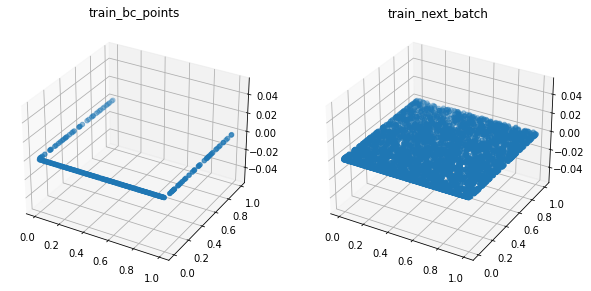

In [2]:
# Create model and plot training data
geomtime_data, model = create_model(const_params, PinnTestParam())
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.033340 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-10 14:57:38.628029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-10 14:57:38.628646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-10 14:57:38.663113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS ha

'compile' took 1.298878 s



2021-12-10 14:57:39.723038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-10 14:57:39.723065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2021-12-10 14:57:39.723070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2021-12-10 14:57:39.723623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 14:57:39.723989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 14:57:39.724319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-

Initializing variables...
Training model...



2021-12-10 14:57:39.984063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Step      Train loss                        Test loss                         Test metric
0         [1.00e-01, 7.26e-01, 2.14e+00]    [1.02e-01, 7.26e-01, 2.14e+00]    []  
1000      [5.02e-03, 6.88e-03, 9.53e-03]    [2.82e-03, 6.88e-03, 9.53e-03]    []  
2000      [1.59e-03, 1.61e-03, 7.53e-04]    [9.28e-04, 1.61e-03, 7.53e-04]    []  
3000      [3.92e-04, 1.83e-04, 7.44e-05]    [2.08e-04, 1.83e-04, 7.44e-05]    []  
4000      [1.01e-04, 4.08e-05, 1.24e-05]    [6.50e-05, 4.08e-05, 1.24e-05]    []  
5000      [5.31e-05, 2.75e-05, 5.51e-06]    [3.64e-05, 2.75e-05, 5.51e-06]    []  
6000      [3.24e-05, 1.82e-05, 3.17e-06]    [2.29e-05, 1.82e-05, 3.17e-06]    []  
7000      [4.65e-05, 4.98e-05, 3.74e-05]    [3.70e-05, 4.98e-05, 3.74e-05]    []  
8000      [1.78e-05, 8.89e-06, 2.27e-06]    [1.35e-05, 8.89e-06, 2.27e-06]    []  
9000      [1.41e-05, 5.91e-06, 7.86e-07]    [1.08e-05, 5.91e-06, 7.86e-07]    []  
10000     [1.09e-04, 1.74e-04, 1.46e-04]    [8.14e-05, 1.74e-04, 1.46e-04]    []

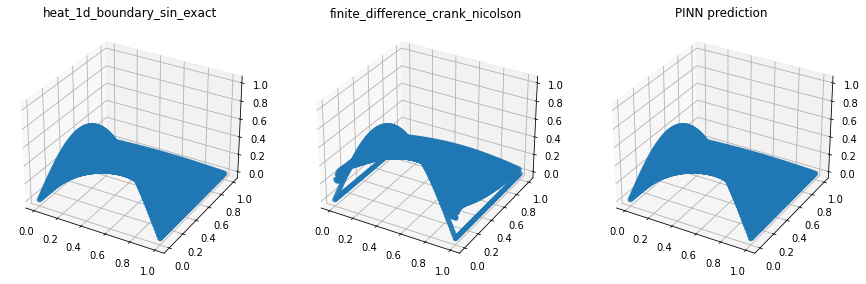

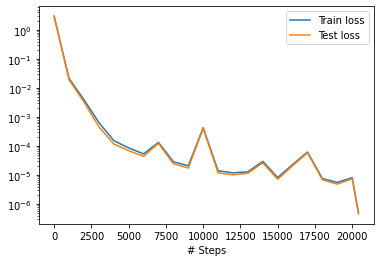

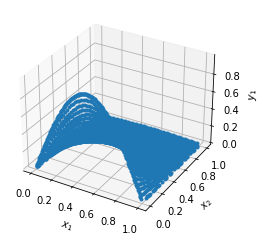

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0005126011
L2 relative error: 0.0003250341178284652


In [3]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 2: Reduce hidden layers and size to break solution

In [4]:
test_params = PinnTestParam()
test_params.nn_hidden_layer_num = 1
test_params.nn_hidden_layer_size = 5

geomtime_data, model = create_model(const_params, test_params)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


Compiling model...
Building feed-forward neural network...
'build' took 0.018614 s

'compile' took 0.131452 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-10 14:58:09.294561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 14:58:09.294958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER compute

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.54e-01, 2.99e-01, 1.78e-01]    [1.63e-01, 2.99e-01, 1.78e-01]    []  
1000      [8.24e-03, 5.17e-02, 1.15e-01]    [6.86e-03, 5.17e-02, 1.15e-01]    []  
2000      [1.41e-02, 3.80e-02, 6.58e-02]    [1.28e-02, 3.80e-02, 6.58e-02]    []  
3000      [7.10e-03, 3.44e-02, 5.01e-02]    [6.46e-03, 3.44e-02, 5.01e-02]    []  
4000      [8.56e-03, 2.67e-02, 3.95e-02]    [7.51e-03, 2.67e-02, 3.95e-02]    []  
5000      [1.18e-02, 2.08e-02, 3.20e-02]    [9.57e-03, 2.08e-02, 3.20e-02]    []  
6000      [1.32e-02, 1.84e-02, 2.77e-02]    [1.05e-02, 1.84e-02, 2.77e-02]    []  
7000      [1.40e-02, 1.74e-02, 2.49e-02]    [1.11e-02, 1.74e-02, 2.49e-02]    []  
8000      [1.52e-02, 1.26e-02, 2.05e-02]    [1.18e-02, 1.26e-02, 2.05e-02]    []  
9000      [1.52e-02, 1.07e-02, 1.86e-02]    [1.17e-02, 1.07e-02, 1.86e-02]    []  
10000     [1.38e-02, 8.34e-03, 1.64

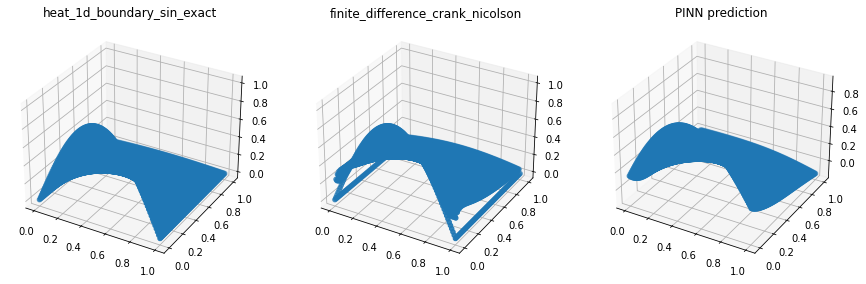

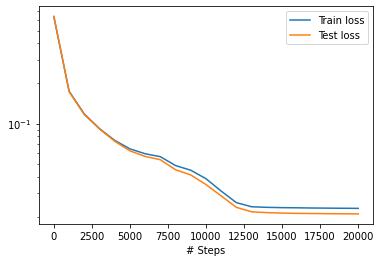

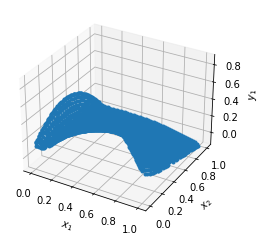

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.07412512
L2 relative error: 0.14655430232227656


In [5]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 3: Reduce boundary points to break solution

train_bc_points shape (6, 2)
train_next_batch shape (2552, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "


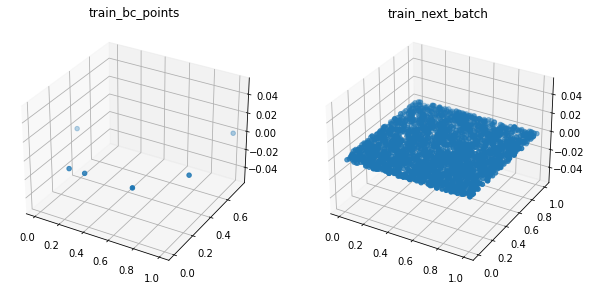

In [6]:
test_params = PinnTestParam()
test_params.d_num_boundary = 3
test_params.d_num_initial = 3

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.034410 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-10 14:58:28.789585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 14:58:28.790026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER compute

'compile' took 0.237996 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.98e-01, 3.50e-01, 1.87e-01]    [1.98e-01, 3.50e-01, 1.87e-01]    []  
1000      [1.87e-03, 4.86e-03, 3.47e-03]    [1.62e-03, 4.86e-03, 3.47e-03]    []  
2000      [5.57e-04, 7.40e-05, 2.30e-04]    [4.83e-04, 7.40e-05, 2.30e-04]    []  
3000      [1.78e-04, 1.37e-06, 7.02e-05]    [1.55e-04, 1.37e-06, 7.02e-05]    []  
4000      [6.59e-05, 1.01e-07, 1.38e-05]    [5.43e-05, 1.01e-07, 1.38e-05]    []  
5000      [4.53e-05, 2.85e-08, 4.23e-06]    [3.66e-05, 2.85e-08, 4.23e-06]    []  
6000      [3.62e-05, 1.62e-08, 2.34e-06]    [2.90e-05, 1.62e-08, 2.34e-06]    []  
7000      [5.83e-05, 1.06e-05, 3.27e-06]    [5.44e-05, 1.06e-05, 3.27e-06]    []  
8000      [3.83e-05, 6.11e-05, 6.44e-05]    [3.01e-05, 6.11e-05, 6.44e-05]    []  
9000      [2.26e-05, 3.65e-09, 1.01e-06]    [1.80e-05, 3.65e-09, 1.01e-06]    []  
10000   

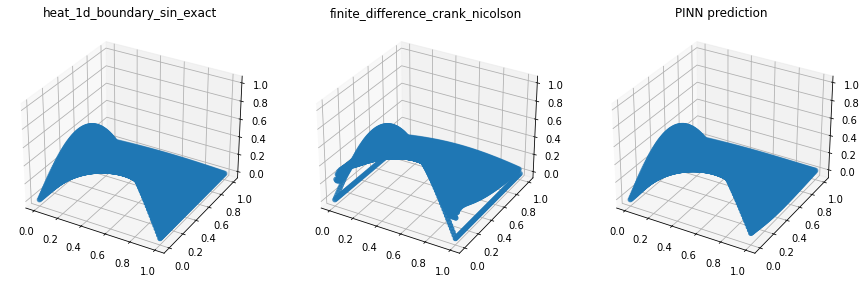

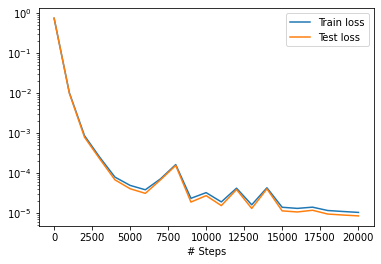

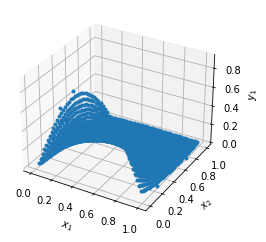

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0024490617
L2 relative error: 0.024105497050349492


In [7]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)

# Test 4: Reduce domain to break solution

train_bc_points shape (240, 2)
train_next_batch shape (530, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


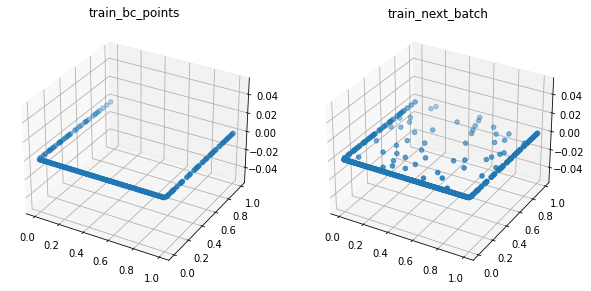

In [8]:
test_params = PinnTestParam()
test_params.d_num_domain = 50

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.034412 s



2021-12-10 14:58:58.088107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 14:58:58.088503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.77GHz coreCount: 40 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.29GiB/s
2021-12-10 14:58:58.088539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-10 14:58:58.088569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-10 14:58:58.088584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-12-10 14:58:58.088597: I tensorflow/stream_ex

'compile' took 0.240036 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.01e-02, 5.55e-02, 8.87e-01]    [5.96e-02, 5.55e-02, 8.87e-01]    []  
1000      [2.58e-03, 1.63e-03, 1.58e-03]    [6.91e-03, 1.63e-03, 1.58e-03]    []  
2000      [6.32e-04, 8.17e-05, 1.46e-04]    [2.43e-03, 8.17e-05, 1.46e-04]    []  
3000      [6.71e-04, 4.29e-05, 7.48e-05]    [1.14e-03, 4.29e-05, 7.48e-05]    []  
4000      [9.13e-04, 4.50e-05, 1.05e-04]    [1.23e-03, 4.50e-05, 1.05e-04]    []  
5000      [1.65e-04, 2.54e-05, 3.22e-05]    [6.73e-04, 2.54e-05, 3.22e-05]    []  
6000      [1.39e-04, 1.86e-05, 2.47e-05]    [5.94e-04, 1.86e-05, 2.47e-05]    []  
7000      [1.20e-04, 1.35e-05, 1.93e-05]    [5.36e-04, 1.35e-05, 1.93e-05]    []  
8000      [1.10e-04, 1.01e-05, 1.60e-05]    [4.99e-04, 1.01e-05, 1.60e-05]    []  
9000      [9.30e-05, 7.41e-06, 1.17e-05]    [4.45e-04, 7.41e-06, 1.17e-05]    []  
10000   

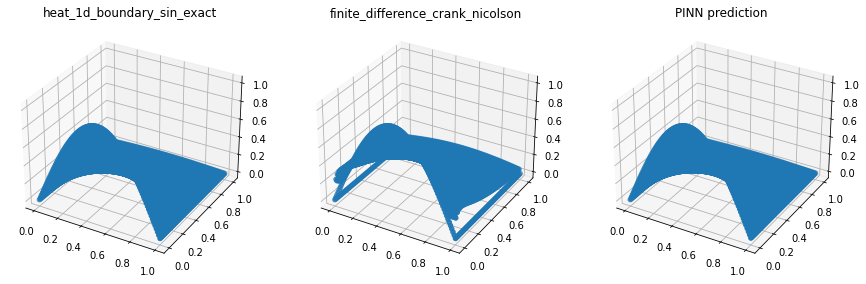

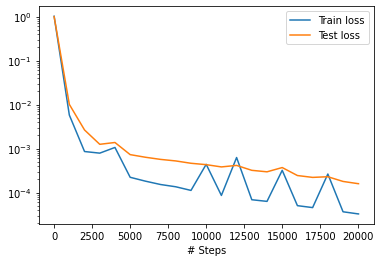

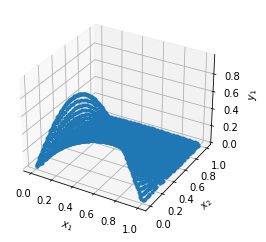

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.00925175
L2 relative error: 0.0035609447870175166


In [9]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 5: Reduce train data (domain and bc) to break solution

train_bc_points shape (20, 2)
train_next_batch shape (90, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "


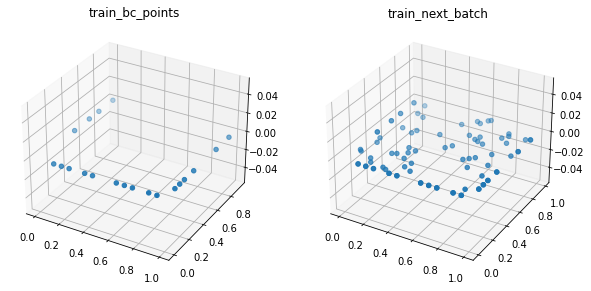

In [10]:
test_params = PinnTestParam()
test_params.d_num_domain = 50
test_params.d_num_boundary = 10
test_params.d_num_initial = 10

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.030561 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-10 14:59:28.178310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 14:59:28.178712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER compute

'compile' took 0.233068 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.23e-02, 8.85e-03, 5.66e-01]    [1.20e-02, 8.85e-03, 5.66e-01]    []  
1000      [5.21e-04, 4.39e-04, 2.80e-05]    [5.12e-03, 4.39e-04, 2.80e-05]    []  
2000      [2.53e-04, 1.17e-04, 9.70e-06]    [1.60e-03, 1.17e-04, 9.70e-06]    []  
3000      [6.80e-05, 1.28e-05, 9.36e-07]    [5.31e-04, 1.28e-05, 9.36e-07]    []  
4000      [1.82e-05, 4.91e-06, 5.06e-07]    [3.61e-04, 4.91e-06, 5.05e-07]    []  
5000      [1.06e-05, 4.04e-06, 4.32e-07]    [3.24e-04, 4.04e-06, 4.32e-07]    []  
6000      [7.85e-06, 3.59e-06, 3.94e-07]    [2.97e-04, 3.59e-06, 3.94e-07]    []  
7000      [6.34e-06, 2.93e-06, 3.63e-07]    [2.78e-04, 2.93e-06, 3.63e-07]    []  
8000      [5.51e-06, 2.57e-06, 3.47e-07]    [2.59e-04, 2.57e-06, 3.47e-07]    []  
9000      [5.23e-06, 2.25e-06, 3.67e-07]    [2.53e-04, 2.25e-06, 3.67e-07]    []  
10000   

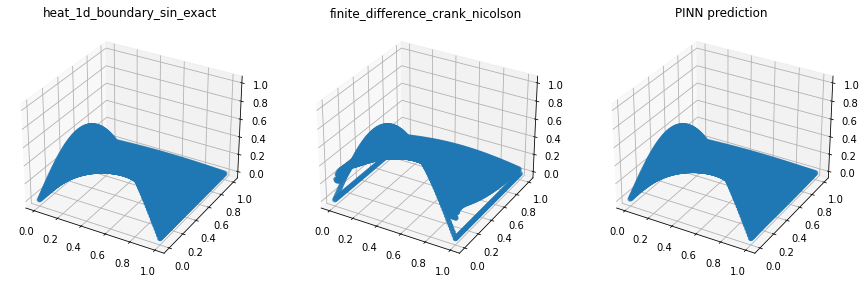

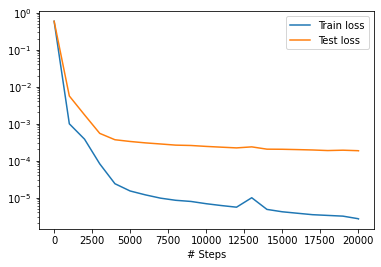

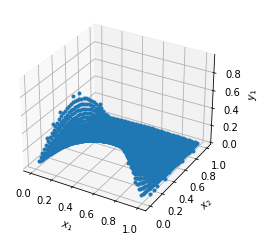

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.005370376
L2 relative error: 0.011047205436611411


In [11]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)
